# Mel Spectrogram Inversion with PyTorch and nnAudio

In [1]:
%load_ext autoreload
%autoreload 2

## Import Dependencies

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Audio
from time import time

import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from nnAudio import Spectrogram

from beatbrain.datasets.audio import AudioClipDataset

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
eps = 1e-12

## Load Audio Sample

In [4]:
AUDIO_PATH = "../data/edm/wav"
SR = 22050

In [5]:
dataset = AudioClipDataset(AUDIO_PATH, sample_rate=SR)
audio, sr = dataset[0]
audio_tensor = torch.tensor(audio, dtype=torch.float32, device=DEVICE)
display(Audio(audio, rate=sr))

## Compute STFT and Mel Spectrograms

In [6]:
N_FFT = 2048
HOP_LENGTH = N_FFT // 8
N_MELS = 256

In [7]:
def psnr(pred, target, target_top=True, top=1e4):
    """
    Peak Signal-to-Noise Ratio (but not really)
    Since spectrograms values are unbounded, this function uses `max(target)` as the maximum possible value by default.
    """
    if target_top:
        top = target.max()
    return 20 * torch.log10(top / torch.sqrt(F.mse_loss(pred, target)))


def psnr_np(pred, target, target_top=True, top=1e4):
    """
    Peak Signal-to-Noise Ratio (but not really) - NumPy version
    Since spectrograms values are unbounded, this function uses `max(target)` as the maximum possible value by default.
    """
    if target_top:
        top = target.max()
    return 20 * np.log10(top / np.sqrt(((pred - target) ** 2).mean()))


def draw_log_spectrogram(S):
    plt.imshow(S, origin="lower", norm=matplotlib.colors.LogNorm())
    plt.colorbar()


def power_to_db(spec, ref=1.0, amin=1e-10, top_db=80.0):
    if amin <= 0:
        raise ValueError('amin must be strictly positive')
    if callable(ref):
        ref_value = ref(spec)
    else:
        ref_value = np.abs(ref)

    amin = torch.tensor(amin, dtype=torch.float32, device=spec.device)
    ref_value = torch.tensor(ref_value, dtype=torch.float32, device=spec.device)

    log_spec = 10.0 * torch.log10(torch.max(amin, spec))
    log_spec -= 10.0 * torch.log10(torch.max(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ValueError('top_db must be non-negative')
        log_spec = torch.max(log_spec, log_spec.max() - top_db)

    return log_spec


def db_to_power(spec_db, ref=1.0):
    return ref * torch.pow(10.0, 0.1 * spec_db)

### STFT Spectrogram

STFT kernels created, time used = 0.2175 seconds


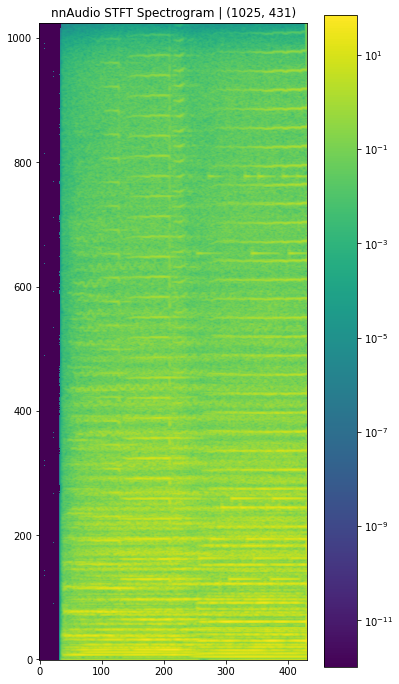

In [8]:
to_stft = Spectrogram.STFT(N_FFT, hop_length=HOP_LENGTH, sr=SR, output_format="Magnitude")
to_stft.to(DEVICE)
stft = to_stft(audio_tensor).clamp(eps)
plt.figure(figsize=(6, 12))
draw_log_spectrogram(stft[0].cpu())
plt.title(f"nnAudio STFT Spectrogram | {tuple(stft[0].shape)}")
plt.show()

### Mel Spectrogram

STFT filter created, time used = 0.0050 seconds
Mel filter created, time used = 0.0060 seconds


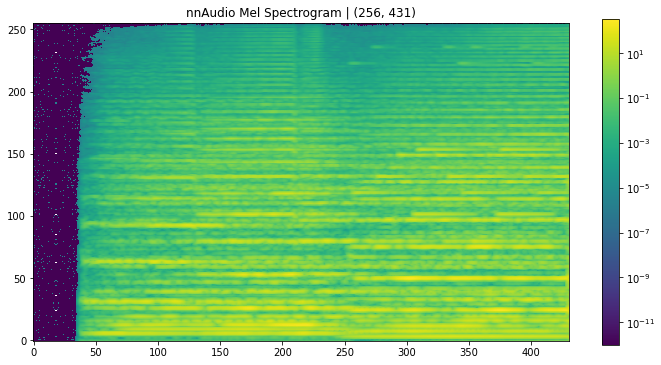

In [9]:
to_mel = Spectrogram.MelSpectrogram(n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, sr=SR)
to_mel.to(DEVICE)
mel = to_mel(audio_tensor).detach().clamp(eps)
plt.figure(figsize=(12, 6))
draw_log_spectrogram(mel[0].cpu())
plt.title(f"nnAudio Mel Spectrogram | {tuple(mel[0].shape)}")
plt.show()

## Reconstruct STFT & Audio from Mel Spectrogram

### librosa (Benchmark)

In [10]:
%%time
librosa_recon_stft = librosa.feature.inverse.mel_to_stft(mel[0].cpu().numpy(), sr=SR, n_fft=N_FFT)

Wall time: 2min 56s


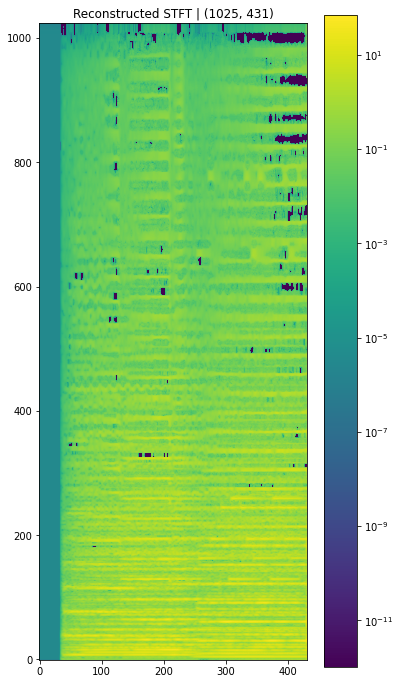

In [11]:
librosa_recon_audio = librosa.griffinlim(librosa_recon_stft, hop_length=HOP_LENGTH)
display(Audio(librosa_recon_audio, rate=SR))

librosa_err = ((librosa_recon_stft - stft.cpu().numpy()) ** 2).mean()

plt.figure(figsize=(6, 12))
draw_log_spectrogram(librosa_recon_stft.clip(eps))
plt.title(f"Reconstructed STFT | {librosa_recon_stft.shape}")
plt.show()

#### Visualize Reconstruction Error

STFT Reconstruction MSE: 1.384e-01
STFT Reconstruction PSNR: 45.442


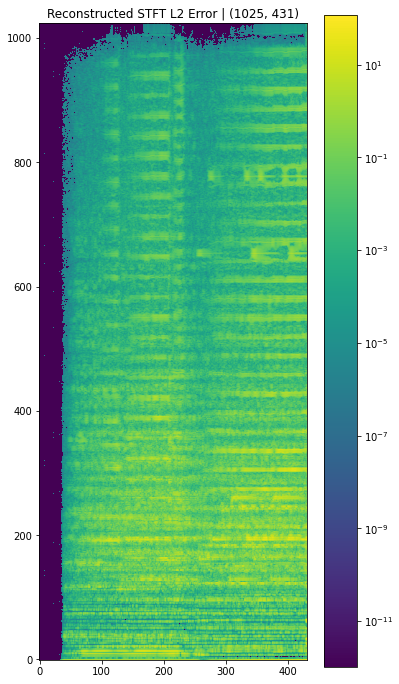

Mel Reconstruction MSE: 8.401e+01
Mel Reconstruction PSNR: 31.481


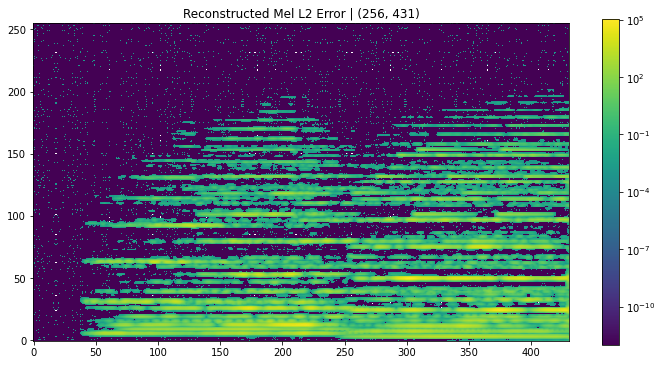

In [12]:
librosa_stft_err_l2 = ((librosa_recon_stft - stft.cpu().numpy()) ** 2).clip(eps)
print(f"STFT Reconstruction MSE: {librosa_stft_err_l2.mean():.3e}")
librosa_stft_psnr = psnr_np(librosa_recon_stft, stft.cpu().numpy())
print(f"STFT Reconstruction PSNR: {librosa_stft_psnr:.3f}")
plt.figure(figsize=(6, 12))
draw_log_spectrogram(librosa_stft_err_l2[0])
plt.title(f"Reconstructed STFT L2 Error | {librosa_stft_err_l2[0].shape}")
plt.show()

librosa_pred_mel = librosa.filters.mel(SR, N_FFT, n_mels=N_MELS) @ librosa_recon_stft
librosa_mel_err_l2 = ((librosa_pred_mel - mel.cpu().numpy()) ** 2).clip(eps)
print(f"Mel Reconstruction MSE: {librosa_mel_err_l2.mean():.3e}")
librosa_mel_psnr = psnr_np(librosa_pred_mel, mel.cpu().numpy())
print(f"Mel Reconstruction PSNR: {librosa_mel_psnr:.3f}")
plt.figure(figsize=(12, 6))
draw_log_spectrogram(librosa_mel_err_l2[0])
plt.title(f"Reconstructed Mel L2 Error | {librosa_mel_err_l2[0].shape}")
plt.show()

### PyTorch Optimization

In [13]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
stft = to_stft(next(iter(dataloader))[0].to(DEVICE)).detach()
mel = to_mel(next(iter(dataloader))[0].to(DEVICE)).detach()

In [14]:
%%time
nnaudio_recon_stft, pred_mel, losses = to_mel.to_stft(mel, return_extras=True, verbose=True, random_start=False)

Target max gradient of 1e-07 reached. Stopping optimization.
Wall time: 5.94 s


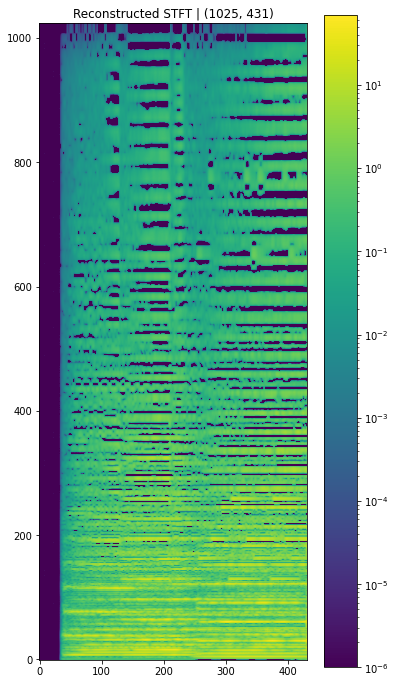

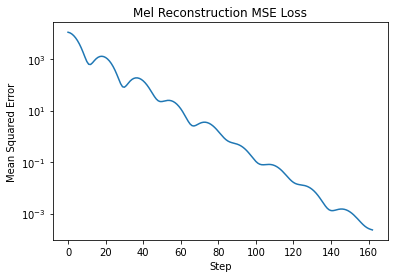

In [15]:
nnaudio_recon_audio = librosa.griffinlim(nnaudio_recon_stft[0].cpu().detach().numpy(), hop_length=HOP_LENGTH)
display(Audio(nnaudio_recon_audio, rate=SR))

plt.figure(figsize=(6, 12))
draw_log_spectrogram(nnaudio_recon_stft[0].cpu().detach())
plt.title(f"Reconstructed STFT | {tuple(nnaudio_recon_stft[0].shape)}")
plt.show()

plt.plot(losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Mean Squared Error")
plt.title("Mel Reconstruction MSE Loss")
plt.show()

#### Visualize Reconstruction Error

STFT Reconstruction MSE: 4.664e-01
STFT Reconstruction PSNR: 48.244


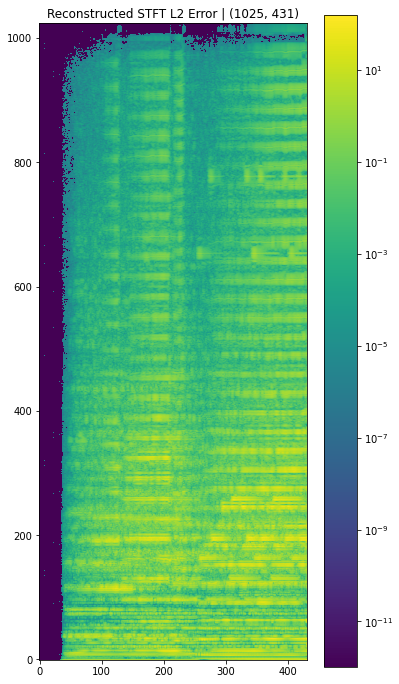

Mel Reconstruction MSE: 9.356e-09
Mel Reconstruction PSNR: 140.670


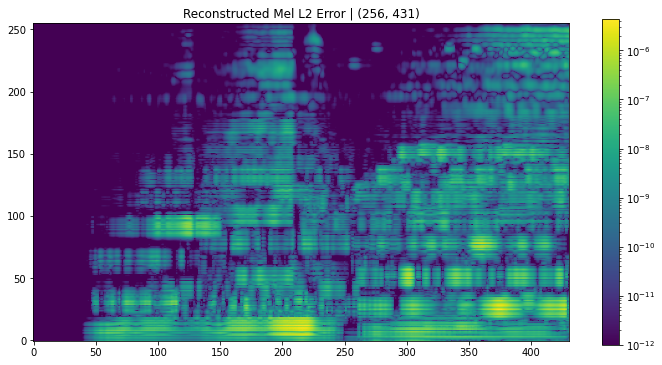

In [16]:
nnaudio_stft_err_l2 = F.mse_loss(nnaudio_recon_stft[0:1], stft[0:1], reduction="none").clamp(eps)
print(f"STFT Reconstruction MSE: {nnaudio_stft_err_l2.mean().item():.3e}")
nnaudio_stft_psnr = psnr(nnaudio_recon_stft, stft)
print(f"STFT Reconstruction PSNR: {nnaudio_stft_psnr.item():.3f}")
plt.figure(figsize=(6, 12))
draw_log_spectrogram(nnaudio_stft_err_l2[0].cpu().numpy())
plt.title(f"Reconstructed STFT L2 Error | {tuple(nnaudio_stft_err_l2[0].shape)}")
plt.show()

nnaudio_mel_err_l2 = F.mse_loss(pred_mel[0:1], mel[0:1], reduction="none").clamp(eps)
print(f"Mel Reconstruction MSE: {nnaudio_mel_err_l2.mean().item():.3e}")
nnaudio_mel_psnr = psnr(pred_mel, mel)
print(f"Mel Reconstruction PSNR: {nnaudio_mel_psnr.item():.3f}")
plt.figure(figsize=(12, 6))
draw_log_spectrogram(nnaudio_mel_err_l2[0].cpu().numpy())
plt.title(f"Reconstructed Mel L2 Error | {tuple(nnaudio_mel_err_l2[0].shape)}")
plt.show()